#Conectamos a google drive e importamos librerias

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
import pandas as pd
!pip install pandas_summary
from pandas_summary import DataFrameSummary
import numpy as np
import datetime
!pip install isoweek
from isoweek import Week
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
!pip install sklearn_pandas
from sklearn_pandas import DataFrameMapper
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras.models import load_model

# Para importar el Helper
%cd "/gdrive/Shareddrives/Redes neuronales/TP2"
!pip install import-ipynb
import import_ipynb
from Helper import *

/gdrive/Shareddrives/Redes neuronales/TP2
importing Jupyter notebook from Helper.ipynb


# Se cargan los archivos preprocesados

Cargamos los archivos que no tienen las sales = 0, porque la competencia de Kaggle dice que no evalua el submit cuando las ventas son 0.

In [ ]:
df = pd.read_feather('data preprecesada/train_normalized_data_!sales0.fth')
df_test = pd.read_feather('data preprecesada/test_normalized_data.fth')

In [ ]:
len(df.columns)

89

Se van a hacer dos modelos, el primero es el que usar los del 3rd lugar de la competencia y el segundo es el que utilizamos nosotras, agregandole las variables de Close_bw y Close_fw generadas en el script de preprocesamiento

# Modelo original de los de tercer lugar

## Preparación variables y Embeddings

### Listamos las variables categóricas

In [ ]:
 cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

#cat_vars = ['Store', 'DayOfWeek']

Una de las cosas que se debe evitar es el Underfitting. Si los datos son muy complejos, si se tuvieran pocas caracteristicas con las que entrenar, el modelo no podría representar dicha complejidad.

Es por esto que, en el preprocesamiento se generan tantas nuevas caracteristicas que no estaban en el dataset original. Además, se establecio a criterio del grupo que tiene que haber minimamente 10 caracteristicas continuas y 10 categoricas para que el modelo tenga confiabilidad.

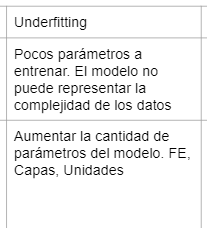

### Listamos las variables continuas

In [ ]:
contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']
#contin_vars = ['BeforeStateHoliday_bool', 'Max_TemperatureC']

In [ ]:
len(contin_vars)+len(cat_vars)

40

In [ ]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [ ]:
DataFrameSummary(df[cat_vars]).summary().loc[['uniques', 'types']]

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_bool_fw,StateHoliday_bool_bw,SchoolHoliday_fw,SchoolHoliday_bw
uniques,1115,7,3,12,31,4,25,26,4,3,4,21,8,12,52,22,6,6,3,3,8,8
types,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric


### Asignación de dimensión de embeddings

In [ ]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 2, 'Year': 2, 'Month': 2,
'Day': 10, 'StateHoliday': 2, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 25, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_bool_fw': 1,
'StateHoliday_bool_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

#### Vemos qué valores pueden tomar cada una de las columnas.
Por ejemplo, para store la dimensión de entrada para embedding será 1115 (puede tomar 1115 valores), pero a la salida del embedding, tendrá una domensión de 50.


In [ ]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print()

Store 50 1115 [   0    1    2 ... 1112 1113 1114]

DayOfWeek 2 7 [0 1 2 3 4 5 6]

Year 2 3 [0 1 2]

Month 2 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Day 10 31 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]

StateHoliday 2 4 [0 1 2 3]

CompetitionMonthsOpen 2 25 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]

Promo2Weeks 1 26 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]

StoreType 2 4 [0 1 2 3]

Assortment 3 3 [0 1 2]

PromoInterval 3 4 [0 1 2 3]

CompetitionOpenSinceYear 4 21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]

Promo2SinceYear 4 8 [0 1 2 3 4 5 6 7]

State 6 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Week 25 52 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]

Events 4 22 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

## Definición del modelo

### Creación de la capa de Embeddings

**get cat vars model**: Es la función que usamos para crear las capas del modelo que se relacionarán con las variables categóricas. Dentro de esta, nuestra primera capa será la de embedding (que solo puede usarse como primera capa del modelo). Embedding se encarga de que datos de alta dimensionalidad se conviertan en datos de baja dimensionalidad (encuentra relaciones entre los datos y baja las dimensiones del problema) que proporcionan mucha información. El embedding se usa entonces como un pre-entrenamiento de los datos.

**get cont vars model**: Aca estamos armando las capas del modelo cuyas variables de entrada son contínuas, por esto no necesitan embedding.

Cada una de las funciones terminan creando una capa para cada una de las variables (categóricas y contínuas).

Estas funciones se encuentran en el Helper

In [ ]:
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

In [ ]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [ ]:
a = [i.shape[1] for i in cat_vars_embed_outs]
uniques.loc['dim embedding'] = np.array(a).T.transpose()
uniques.rename(index={'uniques':'dim cat vars'}, inplace=True)
uniques

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_bool_fw,StateHoliday_bool_bw,SchoolHoliday_fw,SchoolHoliday_bw
dim cat vars,1115,7,3,12,31,4,25,26,4,3,4,21,8,12,52,22,6,6,3,3,8,8
dim embedding,50,2,2,2,10,2,2,1,2,3,3,4,4,6,25,4,1,1,1,1,1,1


Se crea una capa con una neurona para cada variable que describa el registro de la tienda.

### Creamos los modelos 

Se definen los parametros para crear las capas ocultas del modelo. Estás capas vienen directamente después de los Embeddings y los Inputs de las variables continuas.

In [6]:
# Parametros de entrada para creación de las capas ocultas:
cant_capas_ocultas = 2
cantidad_neuronas = [1000, 500]
l2_lambda = 1e-3
activation_function = ["relu","relu"]
alpha = [0, 0] # Se puede cambiar el valor de alpha en caso de usar función LeakyRelu.
# Recordar que el alpha tiene que ser un vector
kernel_initializer = "uniform"

# Parametros de entrada para creación modelo entero:
add_customers = True
output_activation = 'linear'

**MLP_layers**: Función que crea y concatena las capas ocultas con sus respectivas funciones de activación y entre si.

In [ ]:
concatenate_layer = MLP_layers(cat_vars_embed_outs, cont_vars_inputs, l2_lambda, kernel_initializer, cant_capas_ocultas, cant_neuronas= cantidad_neuronas, activation_func= activation_function)

Se unen todas las capas en forma de modelo, lo cual consiste en agrupar las capas creadas en un objeto con funciones de entrenamiento e inferencia.

**crear_MLP**: Se agrupan todas las capas en el modelo deseado. El modelo puede consistir de una capa de salida: 'Sales', o de dos capas: 'Sales' y 'Customers', dependiendo de si se quiere predecir la cantidad de customers también. Para indicar que hacer esta el parametros add_customers.

Con el parametro add_customers = True le pedimos al modelo que calcule la cantidad de ventas y cantidad de clientes. Esto ayuda a lidiar con el overfitting porque ahora los parámetros tienen que satisfacer dos condiciones en simultáneo. También, lo usa como una restricción adicional, como término de regularización y así límita los pesos del modelo.

In [ ]:
model = crear_MLP(add_customers, cat_var_inputs, cont_vars_inputs, concatenate_layer, output_activation)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Store_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
DayOfWeek_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Year_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Month_input (InputLayer)        [(None, 1)]          0                                            
______________________________________________________________________________________________

Hasta acá solo se creo la estructura del modelo y sus capas, todavía no se establecio la función de optimización que se utilizara para ir modificando los pesos, la función de costo, ni la metrica principal para ir midiendo la evolución del entrenamiento del modelo.

Se guardan en un archivo los pesos con los que se inicializo el modelo:

In [ ]:
model.save_weights('modelos generados/initial_weights.hdf5')

### División de datos y tratamientos de estos

Se divide el archivo df en el conjunto de entrenamiento y en el de validación

In [ ]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]

Se separo de esta manera para que se usen las fechas más próximas a las fechas a predecir del test en el conjunto de validación. Se supone que lo que pase en esas fechas en julio puede ser un indicador de lo que va a pasar después en agosto y parte de septiembre (fechas del conjunto de testeo). 




In [ ]:
print(f'Fechas en df_train: {min(df_train.Date)}, - {max(df_train.Date)}')
print(f'Fechas en df_val: {min(df_val.Date)}, - {max(df_val.Date)}')
print(f'Fechas en df_test: {min(df_test.Date)}, - {max(df_test.Date)}')

Fechas en df_train: 2013-01-01 00:00:00, - 2015-06-30 00:00:00
Fechas en df_val: 2015-07-01 00:00:00, - 2015-07-31 00:00:00
Fechas en df_test: 2015-08-01 00:00:00, - 2015-09-17 00:00:00


Se visualiza como son las cantidades en cada conjunto:

In [ ]:
print(f'Cantidad en df_train: {len(df_train)}, porcentaje: {len(df_train)/(len(df) + len(df_test))}')
print(f'Cantidad en df_val: {len(df_val)}, porcentaje: {len(df_val)/(len(df) + len(df_test))}')
print(f'Cantidad en df_test: {len(df_test)}, porcentaje: {len(df_test)/(len(df) + len(df_test))}')
print(f'Cantidad total data: {len(df_test) + len(df_val) + len(df_train)}')

Cantidad en df_train: 814150, porcentaje: 0.9195008956140885
Cantidad en df_val: 30188, porcentaje: 0.034094322958666226
Cantidad en df_test: 41088, porcentaje: 0.04640478142724519
Cantidad total data: 885426


Como estamos trabajando con un conjunto de datos muy grande se divide de forma tal que el 91,95% corresponda al train, un 3,41% al validation y un 4,64% al test. Lo hacemos de esta forma porque entra en la definición de Big Data, por la cantidad de datos que tiene (cercana al millón). De esta manera, se evita Overfitting.

### Entrenamiento del modelo

#### Entreno el  modelo MLP

Tomo las variables continuas y categóricas elegidas con el parámetro *all_vars*.

Con el parámetro *model_chosen*, elijo el nombre del archivo donde se van a guardar los pesos del modelo.

Con el parámetro *log_output* se define el tipo de normalización que se desea hacer. En este caso se elige hacer una normalización por la media y la normal definiendo el parámetro log_ouput = False. 

Con el parámetro *lr* se define el learning rate utilizado para el  algoritmo de optimización Adam. En la práctica es el más usado y suele ser la primera opción. Este algoritmo combina las técnicas SGD y RMSProp para actualizar los pesos de red de forma iterativa en función de los datos de entrenamiento.Además, presenta las siguientes ventajas:

- Fácil de implementar.
- Computacionalmente eficiente.
- Pequeños requisitos de memoria.
- Cambio de escala invariante a diagonal de los gradientes.
- Muy adecuado para problemas que son grandes en términos de datos y / o parámetros.
- Apropiado para objetivos no estacionarios.
- Apropiado para problemas con pendientes muy ruidosas o escasas.
- Los hiperparámetros tienen una interpretación intuitiva y normalmente requieren pocos ajustes.

También se explicitan los valores de la función de costo (loss), epochs, batch size y verbose. 


In [8]:
all_vars = cat_vars + contin_vars #variables elegidas

log_output = False

lr=0.001

metrics=['mse', rmspe]
loss='mse'
epochs = 20
batch_size = 256
verbose=2

model_chosen=f'modelos generados/bestmodel_add_customers_{add_customers}_log_output_{log_output}_lr_{lr}_batch_size_{batch_size}.hdf5'

 **obtener_x_y**: se preparan y normalizan los valores de los datasets de entrenamiento, validación y testeo para poder entrenar el modelo.




In [ ]:
X_train,X_val,X_test,y_train,y_val,y_norm = obtener_x_y(df_train,df_val,df_test,all_vars,add_customers=add_customers,log_output=log_output)

**entrenar_MLP**: se entrena el modelo con los datos de entrenamiento según los parámetros definidos arriba y se guarda el modelo con mejor métrica entre todos los epochs calculados.

In [ ]:
history,model = entrenar_MLP(X_train,X_val,y_train,y_val,all_vars,model=model,add_customers=add_customers,log_output=log_output,lr=lr,metrics=metrics,loss=loss,model_chosen=model_chosen,epochs = epochs,batch_size = batch_size,verbose=verbose)

Epoch 1/20
3181/3181 - 100s - loss: 0.0122 - Sales_loss: 0.0014 - Customers_loss: 5.2316e-04 - Sales_mse: 0.0014 - Sales_rmspe: 0.2697 - Customers_mse: 5.2316e-04 - Customers_rmspe: 0.2636 - val_loss: 0.0014 - val_Sales_loss: 8.2123e-04 - val_Customers_loss: 3.0855e-04 - val_Sales_mse: 8.2123e-04 - val_Sales_rmspe: 0.1919 - val_Customers_mse: 3.0855e-04 - val_Customers_rmspe: 0.1811

Epoch 00001: val_Sales_mse improved from inf to 0.00082, saving model to modelos generados/bestmodel_add_customers_True_log_output_False_lr_0.001_batch_size_256.hdf5
Epoch 2/20
3181/3181 - 92s - loss: 0.0014 - Sales_loss: 8.3950e-04 - Customers_loss: 2.9872e-04 - Sales_mse: 8.3950e-04 - Sales_rmspe: 0.2268 - Customers_mse: 2.9872e-04 - Customers_rmspe: 0.2152 - val_loss: 0.0014 - val_Sales_loss: 8.6989e-04 - val_Customers_loss: 2.6404e-04 - val_Sales_mse: 8.6989e-04 - val_Sales_rmspe: 0.1589 - val_Customers_mse: 2.6404e-04 - val_Customers_rmspe: 0.1440

Epoch 00002: val_Sales_mse did not improve from 0.000

El mejor modelo se calcula con el mse. El mse calcula la media de cuadrados de errores entre etiquetas y predicciones:

$$MSE = \frac{1}{n}\sum^n_{i=1}{(\frac{\hat{y_i}-y_i}{y_i})^2}$$


A continuación, se grafica el error cuadrático medio (mse) del conjunto de validación:




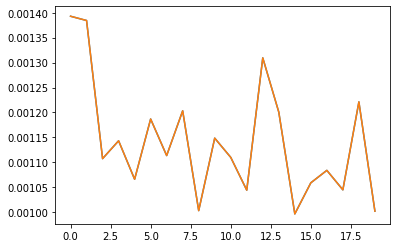

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_loss'])

A continuación, se grafica el error cuadrático medio del conjunto de entrenamiento:

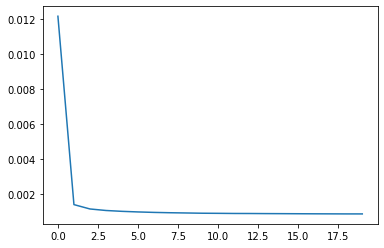

In [ ]:
plt.plot(history.history['loss'])

Conclusiones de los gráficos: 

#### Comparación entre epochs del modelo

Se evalua el modelo fiteado con la cantidad de epochs totales para el conjunto de validación

In [ ]:
model.evaluate(X_val, y_val,return_dict=True)

944/944 [==============================] - 5s 6ms/step - loss: 0.0010 - Sales_loss: 6.8954e-04 - Customers_loss: 2.1856e-04 - Sales_mse: 6.8954e-04 - Sales_rmspe: 0.1439 - Customers_mse: 2.1856e-04 - Customers_rmspe: 0.1291


{'Customers_loss': 0.00021856238890904933,
 'Customers_mse': 0.00021856238890904933,
 'Customers_rmspe': 0.129115492105484,
 'Sales_loss': 0.0006895417463965714,
 'Sales_mse': 0.0006895417463965714,
 'Sales_rmspe': 0.1439155787229538,
 'loss': 0.0010021774796769023}

Se evalua el modelo guardado. Este modelo, como se explico antes, contiene los pesos del mejor epoch que se obtuvo al fitear.

In [ ]:
metricas_prueba = metricas_MLP(X_val,y_val,model,model_chosen='/gdrive/Shareddrives/Redes neuronales/TP2/modelos generados/bestmodel_add_customers_True_log_output_False_lr_0.001_batch_size_256.hdf5')
metricas_prueba

944/944 [==============================] - 6s 5ms/step - loss: 0.0010 - Sales_loss: 6.7203e-04 - Customers_loss: 2.1497e-04 - Sales_mse: 6.7203e-04 - Sales_rmspe: 0.1483 - Customers_mse: 2.1497e-04 - Customers_rmspe: 0.1292


{'Customers_loss': 0.00021497496345546097,
 'Customers_mse': 0.00021497496345546097,
 'Customers_rmspe': 0.12923963367938995,
 'Sales_loss': 0.0006720282835885882,
 'Sales_mse': 0.0006720282835885882,
 'Sales_rmspe': 0.14833779633045197,
 'loss': 0.0010032891295850277}

A partir de acá se trabaja con el modelo elegido, es decir, el que tuvo los mejores resultados.

### Obtención de métricas con el  modelo MLP



Se carga el modelo

In [ ]:
model_chosen='/gdrive/Shareddrives/Redes neuronales/TP2/modelos generados/bestmodel_add_customers_True_log_output_False_lr_0.001_batch_size_256.hdf5'

Para calcular la métrica, se utilizo el error cuadrático medio:

$$RMSPE = \sqrt{\frac{1}{n}\sum^n_{i=1}{(\frac{\hat{y_i}-y_i}{y_i})^2}}$$

Calcula la métrica del porcentaje de error cuadrático medio de la raíz entre y_true y y_pred.

Con la función **metricas_predic_MLP** se obtiene el RMSE a partir de la predicción del dataset de validación obtenida con el modelo ya entrenado y se obtienen las predicciones para el dataset de testeo.

In [ ]:
metricas_prueba = metricas_MLP(X_val,y_val,model,model_chosen=model_chosen)
metricas_prueba

944/944 [==============================] - 6s 5ms/step - loss: 0.0010 - Sales_loss: 6.7203e-04 - Customers_loss: 2.1497e-04 - Sales_mse: 6.7203e-04 - Sales_rmspe: 0.1483 - Customers_mse: 2.1497e-04 - Customers_rmspe: 0.1292


{'Customers_loss': 0.00021497496345546097,
 'Customers_mse': 0.00021497496345546097,
 'Customers_rmspe': 0.12923963367938995,
 'Sales_loss': 0.0006720282835885882,
 'Sales_mse': 0.0006720282835885882,
 'Sales_rmspe': 0.14833779633045197,
 'loss': 0.0010032891295850277}

In [ ]:
metricas_prueba['Sales_rmspe']

0.14833779633045197

#### Time series cross validation

El metodo de validación que se estuvo usando fue el **Holdout cross-validation**, este es el método que usa la función .fit. 

Si bien este es un metodo simple, facil de entender y de implementar, no es adecuado para un conjunto de datos desequilibrado. Otra desventaja es que se aíslan muchos datos del entrenamiento del modelo.

Por esto, se elige usar otro metodo de validación, el **Time Series Cross Validation** para evaluar y comparar las estimaciones que nos den entre ambos metodos.

Con la función **crossval_score_MLP** se van a tomar diferentes datasets de validación para evaluar el modelo. Lo particular de este metodo es que los datasets se van tomando de forma cronologica de la siguiente forma

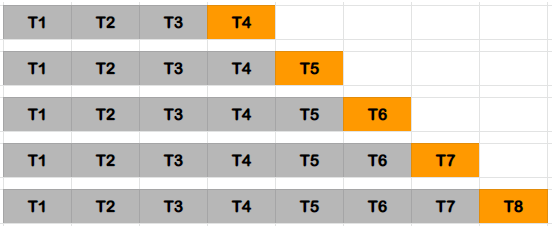

In [ ]:
# Cantidad de particiones para el validation:
k = 5

In [ ]:
metrics_cross = crossval_score_MLP(df,df_test,all_vars,model,k=k,add_customers=add_customers,log_output=log_output,lr=lr,metrics=metrics,loss=loss,epochs = epochs,batch_size = batch_size,verbose=verbose)

Helper.ipynb:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Fechas en df_train:, 2013-01-01 00:00:00, - 2015-02-28 00:00:00
Fechas en df_val:, 2015-03-01 00:00:00, - 2015-03-31 00:00:00
Epoch 1/20
2750/2750 - 84s - loss: 9.9560e-04 - Sales_loss: 6.7679e-04 - Customers_loss: 1.9535e-04 - Sales_mse: 6.7679e-04 - Sales_rmspe: 0.1754 - Customers_mse: 1.9535e-04 - Customers_rmspe: 0.1604 - val_loss: 0.0010 - val_Sales_loss: 7.4492e-04 - val_Customers_loss: 1.7627e-04 - val_Sales_mse: 7.4492e-04 - val_Sales_rmspe: 0.1462 - val_Customers_mse: 1.7627e-04 - val_Customers_rmspe: 0.1415

Epoch 00001: val_Sales_mse improved from inf to 0.00074, saving model to modelos generados/bestmodel_add_customers_True_log_output_False_lr_0.001_batch_size_256_crossval_3.hdf5
Epoch 2/20
2750/2750 - 81s - loss: 9.8413e-04 - Sales_loss: 6.6894e-04 - Customers_loss: 1.9426e-04 - Sales_mse: 6.6894e-04 - Sales_rmspe: 0.1749 - Customers_mse: 1.9426e-04 - Customers_rmspe: 0.1604 - val_loss: 9.7758e-04 - val_Sales_loss: 6.8149e-04 - val_Customers_loss: 1.7656e-04 - val_Sales_ms

##### Se cargan los modelos fiteados

La función **crossval_score_MLP** guarda los *k* modelos fiteados. Se levantan estos modelos y se calculan las siguientes metricas con la función **prom_metrics**

In [ ]:
metric_cross, loss_cross, mean_metrics_cross, mean_loss_cross = prom_metrics(df,df_test,all_vars,model,k=k,add_customers=add_customers,log_output=log_output,lr=lr,metrics=metrics,loss=loss,epochs = epochs,batch_size = batch_size)

Helper.ipynb:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


944/944 [==============================] - 6s 6ms/step - loss: 9.7597e-04 - Sales_loss: 6.5450e-04 - Customers_loss: 2.3792e-04 - Sales_mse: 6.5450e-04 - Sales_rmspe: 0.1454 - Customers_mse: 2.3792e-04 - Customers_rmspe: 0.1432


Se printe las metricas de loss y de rmspe al hacer cross validation

In [ ]:
print(f'RMSPE:, {mean_metrics_cross}')
print(f'Función de costo (loss):, {mean_loss_cross}')

RMSPE:, 0.14684411585330964
Función de costo (loss):, 0.0007753516663797199


Se puede ver que con Hold-Out cross validation y con Time Series Cross Validation nos da el rmspe muy parecido

# Modelo Nuestro

En el script *Eleccion caracteristicas y parametros.ipynb* se evaluaron diferentes modelos, en los cuales se vario la cantidad y caracteristicas que se usaron para hacer los embeddings y los inputs continuos. 

En esta parte, se va a evaluar el modelo que mejor rmspe nos dio.  

Con un valor de Sales_rmspe de 0.1321597844362259, las caracteristicas que usaremos son del modelo 8 de results_eleccion4.


In [4]:
df = pd.read_feather('data preprecesada/train_normalized_data_!sales0.fth')
df_test = pd.read_feather('data preprecesada/test_normalized_data.fth')

## Preparación variables y Embeddings

### Listamos las variables categóricas

In [32]:
results_metrics_csv = pd.read_csv('/gdrive/Shareddrives/Redes neuronales/TP2/eleccion caracteristicas/resultados/results_eleccion4.csv', low_memory=False)
results_metrics_csv

,Unnamed: 0,Cantidad de características,Caracteristicas modelo,Puntaje (Sales_rmspe)
0,0,40,"['Day', 'Assortment', 'Promo_fw', 'SchoolHolid...",0.313863
1,1,35,"['Day', 'Assortment', 'Promo_fw', 'SchoolHolid...",0.282846
2,2,40,"['Day', 'Assortment', 'Promo_fw', 'SchoolHolid...",0.300816
3,3,30,"['Week', 'CompetitionMonthsOpen', 'Store', 'Pr...",0.145316
4,4,25,"['Week', 'CompetitionMonthsOpen', 'Store', 'Pr...",0.145403
5,5,30,"['Week', 'CompetitionMonthsOpen', 'Store', 'Pr...",0.144697
6,6,42,"['Close_bool_bw', 'Assortment', 'CompetitionOp...",0.142531
7,7,37,"['Close_bool_bw', 'Assortment', 'CompetitionOp...",0.138839
8,8,42,"['Close_bool_bw', 'Assortment', 'CompetitionOp...",0.132160


In [33]:
index = results_metrics_csv["Puntaje (Sales_rmspe)"].idxmin()
best_caracteristicas = results_metrics_csv['Caracteristicas modelo'][index]

In [34]:
best_caracteristicas

"['Close_bool_bw', 'Assortment', 'CompetitionOpenSinceYear', 'DayOfWeek', 'StateHoliday_bool_fw', 'State', 'SchoolHoliday', 'Year', 'Week', 'Promo_bw', 'Promo_fw', 'SchoolHoliday_bw', 'StoreType', 'Promo2Weeks', 'Events', 'Day', 'Month', 'Close_bool_fw', 'CompetitionMonthsOpen', 'StateHoliday', 'Promo', 'Promo2', 'PromoInterval', 'Promo2SinceWeek', 'StateHoliday_bool_bw', 'Store', 'Promo2SinceYear', 'AfterSchoolHoliday', 'Mean_TemperatureC', 'AfterStateHoliday_bool', 'AfterPromo', 'Max_TemperatureC', 'Mean_Humidity', 'BeforeStateHoliday_bool', 'Max_Wind_SpeedKm_h', 'trend', 'CompetitionDistance', 'AfterClose_bool', 'trend_DE', 'Precipitationmm', 'CloudCover', 'Min_TemperatureC']"

In [5]:
cat_vars = ['Close_bool_bw', 'Assortment', 'CompetitionOpenSinceYear', 'DayOfWeek', 'StateHoliday_bool_fw', 'State', 'SchoolHoliday', 'Year', 'Week', 'Promo_bw', 'Promo_fw', 'SchoolHoliday_bw', 'StoreType', 'Promo2Weeks', 'Events', 'Day', 'Month', 'Close_bool_fw', 'CompetitionMonthsOpen', 'StateHoliday', 'Promo', 'Promo2', 'PromoInterval', 'Promo2SinceWeek', 'StateHoliday_bool_bw', 'Store', 'Promo2SinceYear']

Como se puede observar, en nuestro modelo se incluyeron las caractristicas de 'Close_bool_bw' y 'Close_bool_fw'

### Listamos las variables continuas

In [6]:
contin_vars = ['AfterSchoolHoliday', 'Mean_TemperatureC', 'AfterStateHoliday_bool', 'AfterPromo', 'Max_TemperatureC', 'Mean_Humidity', 'BeforeStateHoliday_bool', 'Max_Wind_SpeedKm_h', 'trend', 'CompetitionDistance', 'AfterClose_bool', 'trend_DE', 'Precipitationmm', 'CloudCover', 'Min_TemperatureC']

In [ ]:
len(contin_vars)+len(cat_vars)

42

In [9]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [ ]:
DataFrameSummary(df[cat_vars]).summary().loc[['uniques', 'types']]

,Close_bool_bw,Assortment,CompetitionOpenSinceYear,DayOfWeek,StateHoliday_bool_fw,State,SchoolHoliday,Year,Week,Promo_bw,Promo_fw,SchoolHoliday_bw,StoreType,Promo2Weeks,Events,Day,Month,Close_bool_fw,CompetitionMonthsOpen,StateHoliday,Promo,Promo2,PromoInterval,Promo2SinceWeek,StateHoliday_bool_bw,Store,Promo2SinceYear
uniques,7,3,21,7,3,12,2,3,52,6,6,8,4,26,22,31,12,7,25,4,2,2,4,24,3,1115,8
types,numeric,numeric,numeric,numeric,numeric,numeric,bool,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,bool,bool,numeric,numeric,numeric,numeric,numeric


### Asignación de dimensión de embeddings

También cambiamos las dimensiones de los embeddings, en base a el script **TP2-Analisis Embeddings y Resultados.ipynb**

In [7]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 3,'Promo':2, 'Year': 3, 'Month': 4,
'Day': 10, 'StateHoliday': 3,'SchoolHoliday':2, 'Promo2SinceWeek': 3,
'CompetitionMonthsOpen': 4, 'Promo2Weeks': 3,  'Promo2':2, 'StoreType': 2,
 'Assortment': 3, 'PromoInterval': 3,'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 
 'State': 4, 'Events': 7, 'Promo_fw': 4,'Promo_bw': 4, 'Week':10,
 'StateHoliday_bool_fw': 2, 'StateHoliday_bool_bw': 2, 'SchoolHoliday_fw': 2,
'SchoolHoliday_bw': 2,'Close_bool_bw':3,'Close_bool_fw':3}

#### Vemos qué valores pueden tomar cada una de las columnas.



In [ ]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print()

Close_bool_bw 3 7 [0 1 2 3 4 5 6]

Assortment 3 3 [0 1 2]

CompetitionOpenSinceYear 4 21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]

DayOfWeek 3 7 [0 1 2 3 4 5 6]

StateHoliday_bool_fw 2 3 [0 1 2]

State 4 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

SchoolHoliday 2 2 [0 1]

Year 3 3 [0 1 2]

Week 10 52 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]

Promo_bw 4 6 [0 1 2 3 4 5]

Promo_fw 4 6 [0 1 2 3 4 5]

SchoolHoliday_bw 2 8 [0 1 2 3 4 5 6 7]

StoreType 2 4 [0 1 2 3]

Promo2Weeks 3 26 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]

Events 7 22 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]

Day 10 31 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]

Month 4 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Close_bool_fw 3 7 [0 1 2 3 4 5 6]

CompetitionMonthsOpen 

## Definición del modelo

### Creación de la capa de Embeddings

**get cat vars model**: Es la función que usamos para crear las capas del modelo que se relacionarán con las variables categóricas. Dentro de esta, nuestra primera capa será la de embedding (que solo puede usarse como primera capa del modelo). Embedding se encarga de que datos de alta dimensionalidad se conviertan en datos de baja dimensionalidad (encuentra relaciones entre los datos y baja las dimensiones del problema) que proporcionan mucha información. El embedding se usa entonces como un pre-entrenamiento de los datos.

**get cont vars model**: Aca estamos armando las capas del modelo cuyas variables de entrada son contínuas, por esto no necesitan embedding.

Cada una de las funciones terminan creando una capa para cada una de las variables (categóricas y contínuas).

Estas funciones se encuentran en el Helper

In [10]:
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

In [38]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [ ]:
a = [i.shape[1] for i in cat_vars_embed_outs]
uniques.loc['dim embedding'] = np.array(a).T.transpose()
uniques.rename(index={'uniques':'dim cat vars'}, inplace=True)
uniques

,Close_bool_bw,Assortment,CompetitionOpenSinceYear,DayOfWeek,StateHoliday_bool_fw,State,SchoolHoliday,Year,Week,Promo_bw,Promo_fw,SchoolHoliday_bw,StoreType,Promo2Weeks,Events,Day,Month,Close_bool_fw,CompetitionMonthsOpen,StateHoliday,Promo,Promo2,PromoInterval,Promo2SinceWeek,StateHoliday_bool_bw,Store,Promo2SinceYear
dim cat vars,7,3,21,7,3,12,2,3,52,6,6,8,4,26,22,31,12,7,25,4,2,2,4,24,3,1115,8
dim embedding,3,3,4,3,2,4,2,3,10,4,4,2,2,3,7,10,4,3,4,3,2,2,3,3,2,50,4


Se crea una capa con una neurona para cada variable que describa el registro de la tienda.

### Creamos los modelos 

Se definen los parametros para crear las capas ocultas del modelo. Estás capas vienen directamente después de los Embeddings y los Inputs de las variables continuas.

In [11]:
# Parametros de entrada para creación de las capas ocultas:
cant_capas_ocultas = 2
cantidad_neuronas = [1000, 500]
l2_lambda = 1e-3
activation_function = ["relu","relu"]
alpha = [0, 0] # Se puede cambiar el valor de alpha en caso de usar función LeakyRelu.
# Recordar que el alpha tiene que ser un vector
kernel_initializer = "uniform"

# Parametros de entrada para creación modelo entero:
add_customers = True
output_activation = 'linear'

**MLP_layers**: Función que crea y concatena las capas ocultas con sus respectivas funciones de activación y entre si.

In [12]:
concatenate_layer = MLP_layers(cat_vars_embed_outs, cont_vars_inputs, l2_lambda, kernel_initializer, cant_capas_ocultas, cant_neuronas= cantidad_neuronas, activation_func= activation_function)

Se unen todas las capas en forma de modelo, lo cual consiste en agrupar las capas creadas en un objeto con funciones de entrenamiento e inferencia.

**crear_MLP**: Se agrupan todas las capas en el modelo deseado. El modelo puede consistir de una capa de salida: 'Sales', o de dos capas: 'Sales' y 'Customers', dependiendo de si se quiere predecir la cantidad de customers también. Para indicar que hacer esta el parametros add_customers.

Con el parametro add_customers = True le pedimos al modelo que calcule la cantidad de ventas y cantidad de clientes. Esto ayuda a lidiar con el overfitting porque ahora los parámetros tienen que satisfacer dos condiciones en simultáneo. También, lo usa como una restricción adicional, como término de regularización y así límita los pesos del modelo.

In [13]:
model = crear_MLP(add_customers, cat_var_inputs, cont_vars_inputs, concatenate_layer, output_activation)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Close_bool_bw_input (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
Assortment_input (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
CompetitionOpenSinceYear_input  [(None, 1)]          0                                            
__________________________________________________________________________________________________
DayOfWeek_input (InputLayer)    [(None, 1)]          0                                            
______________________________________________________________________________________________

Hasta acá solo se creo la estructura del modelo y sus capas, todavía no se establecio la función de optimización que se utilizara para ir modificando los pesos, la función de costo, ni la metrica principal para ir midiendo la evolución del entrenamiento del modelo.

Se guardan en un archivo los pesos con los que se inicializo el modelo:

In [41]:
model.save_weights('modelos generados/initial_weights_ourModel.hdf5')

### División de datos y tratamientos de estos

Se divide el archivo df en el conjunto de entrenamiento y en el de validación

In [14]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]

Se separo de esta manera para que se usen las fechas más próximas a las fechas a predecir del test en el conjunto de validación. Se supone que lo que pase en esas fechas en julio puede ser un indicador de lo que va a pasar después en agosto y parte de septiembre (fechas del conjunto de testeo). 




In [ ]:
print(f'Fechas en df_train: {min(df_train.Date)}, - {max(df_train.Date)}')
print(f'Fechas en df_val: {min(df_val.Date)}, - {max(df_val.Date)}')
print(f'Fechas en df_test: {min(df_test.Date)}, - {max(df_test.Date)}')

Fechas en df_train: 2013-01-01 00:00:00, - 2015-06-30 00:00:00
Fechas en df_val: 2015-07-01 00:00:00, - 2015-07-31 00:00:00
Fechas en df_test: 2015-08-01 00:00:00, - 2015-09-17 00:00:00


Se visualiza como son las cantidades en cada conjunto:

In [ ]:
print(f'Cantidad en df_train: {len(df_train)}, porcentaje: {len(df_train)/(len(df) + len(df_test))}')
print(f'Cantidad en df_val: {len(df_val)}, porcentaje: {len(df_val)/(len(df) + len(df_test))}')
print(f'Cantidad en df_test: {len(df_test)}, porcentaje: {len(df_test)/(len(df) + len(df_test))}')
print(f'Cantidad total data: {len(df_test) + len(df_val) + len(df_train)}')

Cantidad en df_train: 814150, porcentaje: 0.9195008956140885
Cantidad en df_val: 30188, porcentaje: 0.034094322958666226
Cantidad en df_test: 41088, porcentaje: 0.04640478142724519
Cantidad total data: 885426


Como estamos trabajando con un conjunto de datos muy grande se divide de forma tal que el 91,95% corresponda al train, un 3,41% al validation y un 4,64% al test. Lo hacemos de esta forma porque entra en la definición de Big Data, por la cantidad de datos que tiene (cercana al millón). De esta manera, se evita Overfitting.

### Entrenamiento del modelo

#### Entreno el  modelo MLP

Tomo las variables continuas y categóricas elegidas con el parámetro *all_vars*.

Con el parámetro *model_chosen*, elijo el nombre del archivo donde se van a guardar los pesos del modelo.

Con el parámetro *log_output* se define el tipo de normalización que se desea hacer. En este caso se elige hacer una normalización por la media y la normal definiendo el parámetro log_ouput = False. 

Con el parámetro *lr* se define el learning rate utilizado para el  algoritmo de optimización Adam. En la práctica es el más usado y suele ser la primera opción. Este algoritmo combina las técnicas SGD y RMSProp para actualizar los pesos de red de forma iterativa en función de los datos de entrenamiento.Además, presenta las siguientes ventajas:

- Fácil de implementar.
- Computacionalmente eficiente.
- Pequeños requisitos de memoria.
- Cambio de escala invariante a diagonal de los gradientes.
- Muy adecuado para problemas que son grandes en términos de datos y / o parámetros.
- Apropiado para objetivos no estacionarios.
- Apropiado para problemas con pendientes muy ruidosas o escasas.
- Los hiperparámetros tienen una interpretación intuitiva y normalmente requieren pocos ajustes.

También se explicitan los valores de la función de costo (loss), epochs, batch size y verbose. 


In [15]:
all_vars = cat_vars + contin_vars #variables elegidas

log_output = True

lr=0.001

metrics=['mse', rmspe]
loss='mse'
epochs = 20
batch_size = 256
verbose=2

model_chosen_nuestro=f'modelos generados/bestmodel_nuestro_add_customers_{add_customers}_log_output_{log_output}_lr_{lr}_batch_size_{batch_size}.hdf5'

 **obtener_x_y**: se preparan y normalizan los valores de los datasets de entrenamiento, validación y testeo para poder entrenar el modelo.




In [16]:
X_train,X_val,X_test,y_train,y_val,y_norm = obtener_x_y(df_train,df_val,df_test,all_vars,add_customers=add_customers,log_output=log_output)

**entrenar_MLP**: se entrena el modelo con los datos de entrenamiento según los parámetros definidos arriba y se guarda el modelo con mejor métrica entre todos los epochs calculados.

In [17]:
history,model = entrenar_MLP(X_train,X_val,y_train,y_val,all_vars,model=model,add_customers=add_customers,log_output=log_output,lr=lr,metrics=metrics,loss=loss,model_chosen=model_chosen_nuestro,epochs = epochs,batch_size = batch_size,verbose=verbose)

Epoch 1/20
3181/3181 - 100s - loss: 0.0203 - Sales_loss: 0.0016 - Customers_loss: 0.0016 - Sales_mse: 0.0016 - Sales_rmspe: 0.0327 - Customers_mse: 0.0016 - Customers_rmspe: 0.0382 - val_loss: 0.0010 - val_Sales_loss: 3.5588e-04 - val_Customers_loss: 3.8066e-04 - val_Sales_mse: 3.5588e-04 - val_Sales_rmspe: 0.0224 - val_Customers_mse: 3.8066e-04 - val_Customers_rmspe: 0.0260

Epoch 00001: val_Sales_mse improved from inf to 0.00036, saving model to modelos generados/bestmodel_nuestro_add_customers_True_log_output_True_lr_0.001_batch_size_256.hdf5
Epoch 2/20
3181/3181 - 96s - loss: 9.3534e-04 - Sales_loss: 3.3647e-04 - Customers_loss: 3.9983e-04 - Sales_mse: 3.3647e-04 - Sales_rmspe: 0.0230 - Customers_mse: 3.9983e-04 - Customers_rmspe: 0.0287 - val_loss: 7.6356e-04 - val_Sales_loss: 2.7974e-04 - val_Customers_loss: 3.3871e-04 - val_Sales_mse: 2.7974e-04 - val_Sales_rmspe: 0.0195 - val_Customers_mse: 3.3871e-04 - val_Customers_rmspe: 0.0241

Epoch 00002: val_Sales_mse improved from 0.000

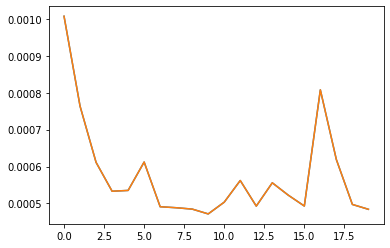

In [18]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_loss'])

A continuación, se grafica el error cuadrático medio del conjunto de entrenamiento:

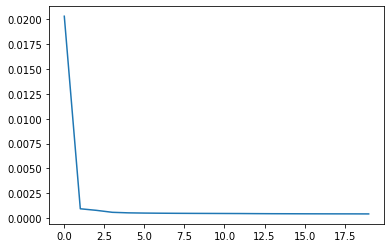

In [19]:
plt.plot(history.history['loss'])

#### Comparación entre epochs del modelo

Se evalua el modelo fiteado con la cantidad de epochs totales para el conjunto de validación

In [20]:
model.evaluate(X_val, y_val,return_dict=True)

944/944 [==============================] - 5s 6ms/step - loss: 4.8396e-04 - Sales_loss: 2.0328e-04 - Customers_loss: 2.2835e-04 - Sales_mse: 2.0328e-04 - Sales_rmspe: 0.0168 - Customers_mse: 2.2835e-04 - Customers_rmspe: 0.0199


{'Customers_loss': 0.0002283465291839093,
 'Customers_mse': 0.0002283465291839093,
 'Customers_rmspe': 0.019894367083907127,
 'Sales_loss': 0.00020327609672676772,
 'Sales_mse': 0.00020327609672676772,
 'Sales_rmspe': 0.016827894374728203,
 'loss': 0.00048395624617114663}

Se evalua el modelo guardado. Este modelo, como se explico antes, contiene los pesos del mejor epoch que se obtuvo al fitear.

In [22]:
metricas_prueba = metricas_MLP(X_val,y_val,model,model_chosen='/gdrive/Shareddrives/Redes neuronales/TP2/modelos generados/bestmodel_nuestro_add_customers_True_log_output_True_lr_0.001_batch_size_256.hdf5')
metricas_prueba

944/944 [==============================] - 6s 6ms/step - loss: 4.8451e-04 - Sales_loss: 1.9213e-04 - Customers_loss: 2.2800e-04 - Sales_mse: 1.9213e-04 - Sales_rmspe: 0.0164 - Customers_mse: 2.2800e-04 - Customers_rmspe: 0.0199


{'Customers_loss': 0.000228004006203264,
 'Customers_mse': 0.000228004006203264,
 'Customers_rmspe': 0.019904498010873795,
 'Sales_loss': 0.00019213033374398947,
 'Sales_mse': 0.00019213033374398947,
 'Sales_rmspe': 0.01635736972093582,
 'loss': 0.0004845138464588672}

A partir de acá se trabaja con el modelo elegido, es decir, el que tuvo los mejores resultados.

### Obtención de métricas con el  modelo MLP



Se carga el modelo

In [23]:
model_chosen=f'/gdrive/Shareddrives/Redes neuronales/TP2/modelos generados/bestmodel_nuestro_add_customers_{add_customers}_log_output_{log_output}_lr_{lr}_batch_size_{batch_size}.hdf5'

In [24]:
metricas_prueba = metricas_MLP(X_val,y_val,model,model_chosen=model_chosen)
metricas_prueba

944/944 [==============================] - 6s 5ms/step - loss: 4.8451e-04 - Sales_loss: 1.9213e-04 - Customers_loss: 2.2800e-04 - Sales_mse: 1.9213e-04 - Sales_rmspe: 0.0164 - Customers_mse: 2.2800e-04 - Customers_rmspe: 0.0199


{'Customers_loss': 0.000228004006203264,
 'Customers_mse': 0.000228004006203264,
 'Customers_rmspe': 0.019904498010873795,
 'Sales_loss': 0.00019213033374398947,
 'Sales_mse': 0.00019213033374398947,
 'Sales_rmspe': 0.01635736972093582,
 'loss': 0.0004845138464588672}

In [25]:
metricas_prueba['Sales_rmspe']

0.01635736972093582

En este script no se corrio el Time series cross validation



#Predicción de ventas

In [26]:
model_chosen=f'/gdrive/Shareddrives/Redes neuronales/TP2/modelos generados/bestmodel_nuestro_add_customers_{add_customers}_log_output_{log_output}_lr_{lr}_batch_size_{batch_size}.hdf5'
y_pred_test = predic_MLP(df_test,X_test,y_norm,model,add_customers=add_customers,log_output=log_output,lr=lr,metrics=metrics,loss=loss,model_chosen=model_chosen,verbose=verbose)
y_pred_test

1284/1284 [==============================] - 6s 4ms/step


array([ 4623.052 ,  6718.9614,  8395.482 , ...,  6580.721 , 24722.945 ,
        7504.87  ], dtype=float32)

###Submit a la competicion

In [27]:
sample_csv = pd.read_csv('/gdrive/Shareddrives/Redes neuronales/TP2/submission/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.to_csv(f'/gdrive/Shareddrives/Redes neuronales/TP2/submission/submision_Rossmann_add_customers_{add_customers}-log_output_{log_output}-out_activation_{output_activation}-l2_lamba_{l2_lambda}-first_hidden_units_{cantidad_neuronas[0]}-epochs_{epochs}-batch_size_{batch_size}-lr_{lr}.csv', index=False)

In [28]:
sample_csv.head()

,Id,Sales
0,1,4623.051758
1,2,6718.961426
2,3,8395.482422
3,4,5049.046387
4,5,6515.265625
